<a href="https://colab.research.google.com/github/baeksumin/k-project/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 전처리

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch.optim as optim
from google.colab import drive
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/[Shared]K-Project/data/mktcap_top10/KR7006840003.csv')

In [4]:
data

,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,2021/12/30,0,0,0,0,0,NaN
1,2021/12/29,0,0,0,0,0,NaN
2,2021/12/28,0,0,0,0,0,NaN
3,2021/12/27,0,0,0,0,0,NaN
4,2021/12/24,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...
5525,1999/08/17,0,0,1,0,0,NaN
5526,1999/08/16,0,0,1,1,0,NaN
5527,1999/08/13,0,0,1,1,0,NaN
5528,1999/08/12,0,0,1,1,0,NaN


In [5]:
data['TREND'].isnull().sum()

24

In [6]:
data['TREND'] = data['TREND'].fillna(0)

In [7]:
data.isnull().sum()

TRD_DD     0
GDC_sig    0
RSI_sig    0
ROC_sig    0
MAP_sig    0
STC_sig    0
TREND      0
dtype: int64

In [8]:
#최신 데이터가 뒤로 오도록 정렬
data = data.sort_values(by=['TRD_DD'])
data.set_index('TRD_DD',drop=True,inplace=True)
data.reset_index('TRD_DD',drop=False,inplace=True)
data

,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,1999/08/11,0,0,-1,1,0,0.0
1,1999/08/12,0,0,1,1,0,0.0
2,1999/08/13,0,0,1,1,0,0.0
3,1999/08/16,0,0,1,1,0,0.0
4,1999/08/17,0,0,1,0,0,0.0
...,...,...,...,...,...,...,...
5525,2021/12/24,0,0,0,0,0,0.0
5526,2021/12/27,0,0,0,0,0,0.0
5527,2021/12/28,0,0,0,0,0,0.0
5528,2021/12/29,0,0,0,0,0,0.0


In [9]:
Y_colname = ['TREND'] #종속변수
X_remove = ['TRD_DD']
X_colname = [x for x in data.columns if x not in Y_colname + X_remove] #입력변수들
X_colname

['GDC_sig', 'RSI_sig', 'ROC_sig', 'MAP_sig', 'STC_sig']

In [10]:
def datasplit(df, Y_colname, X_colname): #데이터 분리 함수
  df_train = df.loc[0 : round(len(df) * 0.75)] 
  df_test = df.loc[round(len(df) * 0.75) + 1 : ]
  Y_train = df_train[Y_colname]
  X_train = df_train[X_colname]
  Y_test = df_test[Y_colname]
  X_test = df_test[X_colname]
  return X_train, X_test, Y_train, Y_test

In [11]:
X_train, X_test, Y_train, Y_test = datasplit(data, Y_colname, X_colname)

In [12]:
print('X_train :', X_train.shape, 'Y_train :', Y_train.shape) 
print('X_test :', X_test.shape, 'Y_test :', Y_test.shape)

X_train : (4149, 5) Y_train : (4149, 1)
X_test : (1381, 5) Y_test : (1381, 1)


In [13]:
Y_train

,TREND
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
4144,-0.333333
4145,-0.250000
4146,-0.166667
4147,-0.083333


# 3차원 데이터로 변환

In [14]:
#array로 변환
X_train_arr = X_train.values
Y_train_arr = Y_train.values
X_test_arr = X_test.values
Y_test_arr = Y_test.values

In [15]:
seq_length = 17 #몇개의 입력데이터로 차분 데이터 생성할지에 대한 파라미터. 지금은 12라고 가정. 나중에 반복문을 통해 sequence 최적화가 필요할듯.
X_train, Y_train = [], []
for index in range(len(X_train_arr) - seq_length): #sequence개의 데이터만큼 차분데이터 분석에 사용하므로, 총 데이터 개수 - sequence개수가 전체 데이터의 길이 --> 총길이만큼 돌리는 것이므로, 기존 차원을 뜻하는 (row, column) 꼴에는 변함 없음 --> 2차원 데이터
  X_train.append(np.array(X_train_arr[index:index + seq_length])) #X_train 데이터 --> index가 sequence인 1차원 데이터 생성 --> sequence를 뜻하는 차원 생성
  Y_train.append(np.ravel(Y_train_arr[index + seq_length:index + seq_length + 1])) #Y_train 데이터 --> index가 sequence인 1차원 데이터 생성 --> 그러나 ravel() 로 차원축소 --> sequence차원 생성되지 않음.
X_train, Y_train = np.array(X_train), np.array(Y_train) #array로 저장되어있는 리스트를 array로 변환해서 저장

In [16]:
X_test, Y_test = [], [] #동일한 과정 test데이터셋에도 적용
for index in range(len(X_test_arr) - seq_length):
  X_test.append(np.array(X_test_arr[index:index + seq_length])) 
  Y_test.append(np.ravel(Y_test_arr[index + seq_length:index + seq_length + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [17]:
print('X_train :', X_train.shape, 'Y_train :', Y_train.shape) #X/Y 분리가 잘 됨. 데이터 전처리 과정 완료
print('X_test :', X_test.shape, 'Y_test :', Y_test.shape)

X_train : (4132, 17, 5) Y_train : (4132, 1)
X_test : (1364, 17, 5) Y_test : (1364, 1)


# 모델링

In [18]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM, SimpleRNN, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D
import matplotlib.pyplot as plt

In [19]:
batch_size = 40 #미니 배치 내 데이터 수
epoch = 80 #돌릴 횟수

In [20]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))  #은닉층 노드 수, 커널 크기(window -> 패턴 추출을 위해 7일 -2일(휴일) 즉, 일주일의 패턴을 습득, 돌아보겠다.)
model.add(MaxPooling1D(3))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 32)            832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 32)            0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_fit = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epoch, verbose=1) #모델 피팅

Epoch 1/80
104/104 [==============================] - 4s 7ms/step - loss: 0.3265
Epoch 2/80
104/104 [==============================] - 1s 7ms/step - loss: 0.2991
Epoch 3/80
104/104 [==============================] - 1s 8ms/step - loss: 0.2875
Epoch 4/80
104/104 [==============================] - 1s 8ms/step - loss: 0.2852
Epoch 5/80
104/104 [==============================] - 1s 8ms/step - loss: 0.2799
Epoch 6/80
104/104 [==============================] - 1s 8ms/step - loss: 0.2756
Epoch 7/80
104/104 [==============================] - 1s 8ms/step - loss: 0.2738
Epoch 8/80
104/104 [==============================] - 1s 7ms/step - loss: 0.2725
Epoch 9/80
104/104 [==============================] - 1s 7ms/step - loss: 0.2691
Epoch 10/80
104/104 [==============================] - 1s 7ms/step - loss: 0.2696
Epoch 11/80
104/104 [==============================] - 1s 8ms/step - loss: 0.2657
Epoch 12/80
104/104 [==============================] - 1s 7ms/step - loss: 0.2648
Epoch 13/80
104/104 [====

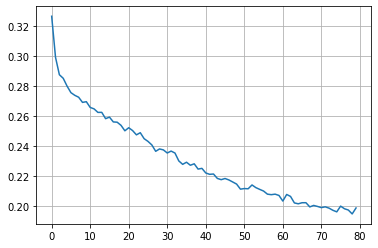

In [22]:
plt.plot(pd.DataFrame(model_fit.history)) #모델 피팅 결과 시각화
plt.grid(True)
plt.show()

In [23]:
Y_train_pred = model.predict(X_train) #예측 데이터 생성
Y_test_pred = model.predict(X_test)

In [24]:
score_table = pd.DataFrame(Y_test, columns=['trend'])
score_table['signal'] = Y_test_pred
score_table

,trend,signal
0,-0.925926,-0.399543
1,-0.703704,-0.461665
2,-0.629630,-0.289811
3,-0.555556,-0.354041
4,-0.481481,-0.303100
...,...,...
1359,0.000000,0.127874
1360,0.000000,0.127874
1361,0.000000,0.127874
1362,0.000000,0.127874


In [25]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(score_table['trend'], score_table['signal'])
RMSE = np.sqrt(MSE)

In [26]:
print("MSE : {0}, RMSE : {1}".format(MSE, RMSE))

MSE : 0.30682514141904227, RMSE : 0.5539179916007805


#모델 결과 시각화 및 평가

In [27]:
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(30,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Upper: Training Set, Lower: Test Set', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual

In [28]:
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

43/43 [==============================] - 0s 2ms/step - loss: 5.6400e-16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


,MAE,MSE,MAPE
Train,0.332412,0.181291,inf
Test,0.463475,0.306825,inf


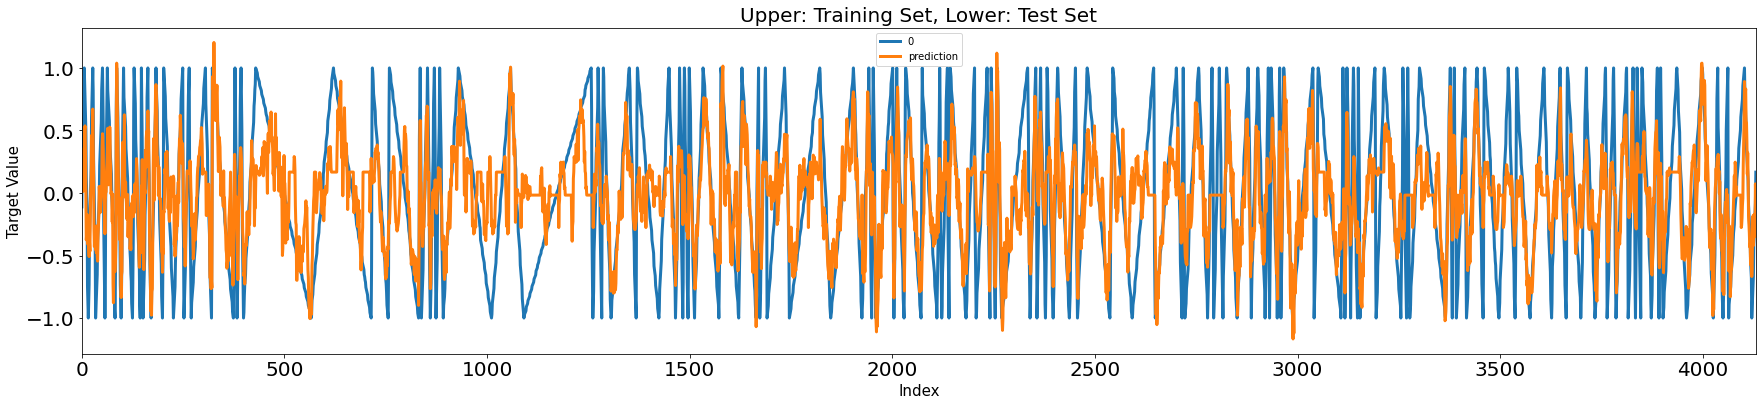

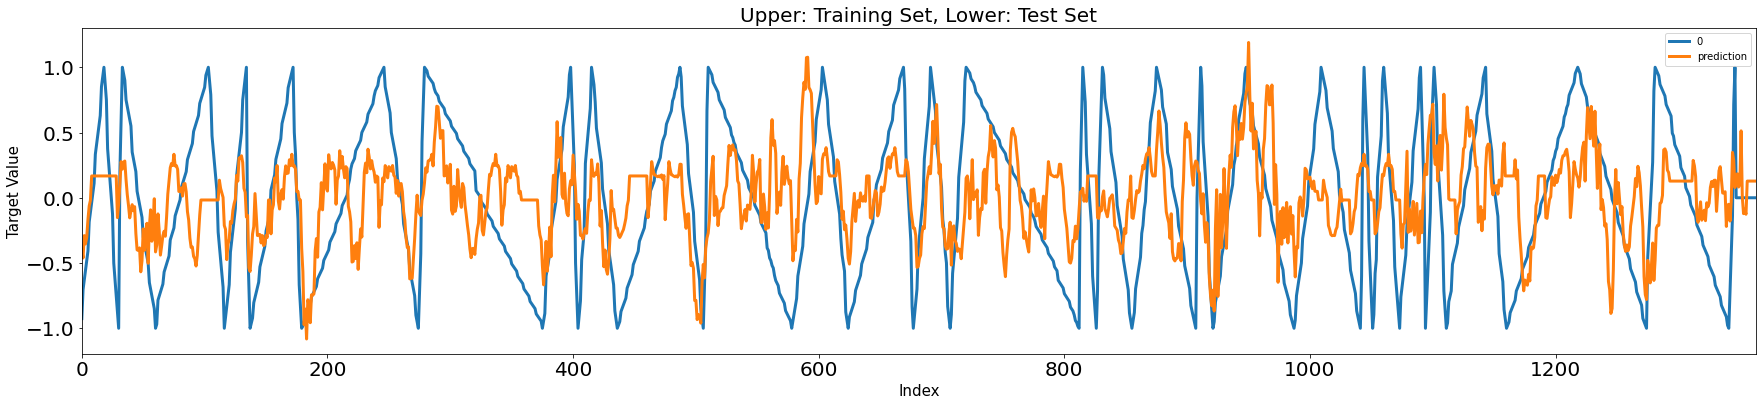

In [29]:
result = model.evaluate(X_test, Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# 성능 평가지표인 백테스트에 넣기 위한 전처리

In [30]:
Y_colname = ['TREND'] #종속변수
X_remove = ['TRD_DD']
X_colname = [x for x in data.columns if x not in Y_colname + X_remove] #입력변수들
X_data = data[X_colname]
Y_data = data[Y_colname]

In [31]:
X_data_arr = X_data.values
Y_data_arr = Y_data.values

In [32]:
seq_length = 17

In [33]:
X_data, Y_data = [], []
for index in range(len(X_data_arr) - seq_length):
  X_data.append(np.array(X_data_arr[index:index + seq_length])) 
  Y_data.append(np.ravel(Y_data_arr[index + seq_length:index + seq_length + 1]))
X_data, Y_data = np.array(X_data), np.array(Y_data)

In [34]:
print('X_data :', X_data.shape, 'Y_data :', Y_data.shape)

X_data : (5513, 17, 5) Y_data : (5513, 1)


In [35]:
signal_prediction = model.predict(X_data)

In [36]:
data = data[seq_length:]

In [37]:
len(signal_prediction)

5513

In [38]:
data['signal'] = signal_prediction
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND,signal
17,1999/09/03,0,0,-1,0,0,-0.111111,0.031193
18,1999/09/06,0,0,-1,0,0,0.222222,0.013960
19,1999/09/07,0,0,-1,0,0,0.333333,0.019731
20,1999/09/08,0,0,-1,0,0,0.444444,0.012971
21,1999/09/09,0,0,-1,0,0,0.555556,0.145023
...,...,...,...,...,...,...,...,...
5525,2021/12/24,0,0,0,0,0,0.000000,0.127874
5526,2021/12/27,0,0,0,0,0,0.000000,0.127874
5527,2021/12/28,0,0,0,0,0,0.000000,0.127874
5528,2021/12/29,0,0,0,0,0,0.000000,0.127874


In [39]:
df_test = data.loc[round(len(data) * 0.75) + 1 : ]

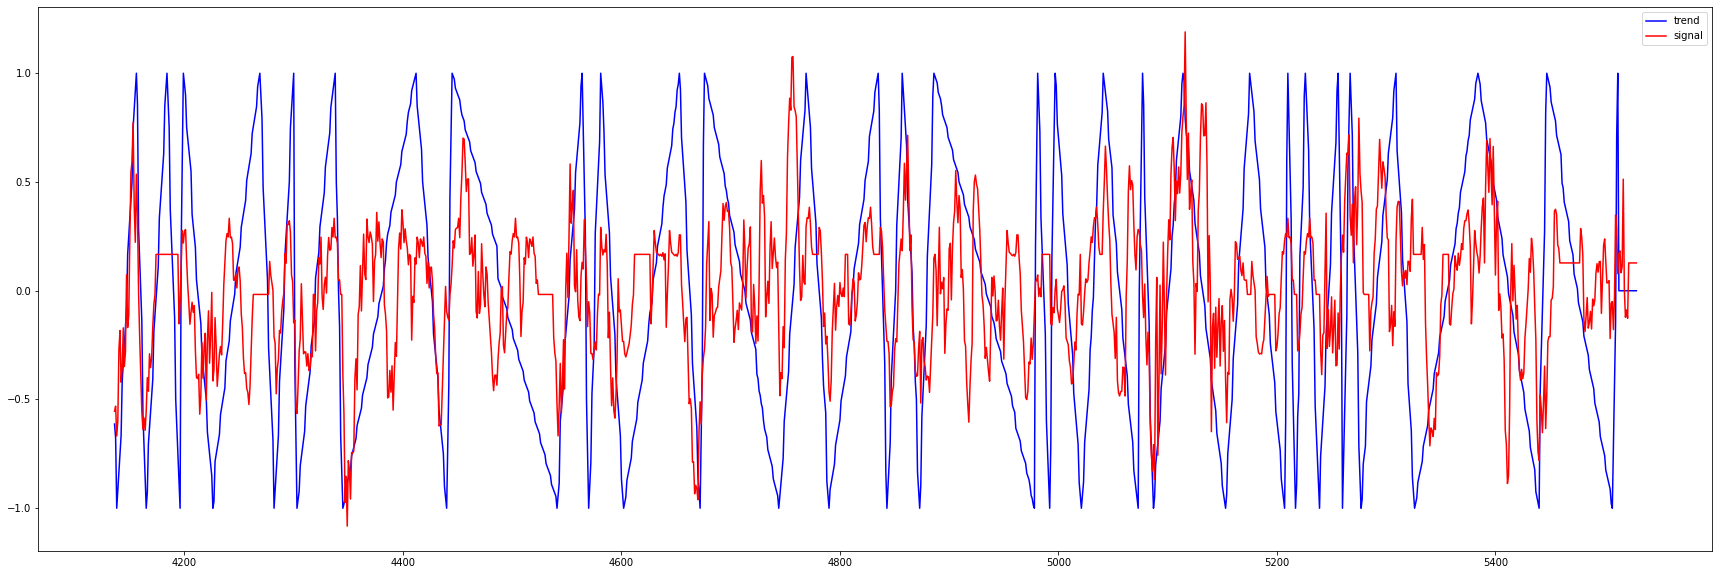

In [40]:
plt.figure(figsize=(30,10))
plt.plot(df_test['TREND'], 'b-', label = 'trend')
plt.plot(df_test['signal'], 'r-', label = 'signal')
plt.legend()
plt.show()

In [41]:
df_test

,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND,signal
4136,2016/05/03,0,0,-1,0,0,-0.612903,-0.553926
4137,2016/05/04,0,0,-1,0,0,-0.677419,-0.530804
4138,2016/05/09,0,0,1,0,0,-1.000000,-0.667962
4139,2016/05/10,0,0,1,0,0,-0.916667,-0.598620
4140,2016/05/11,0,0,1,0,-1,-0.833333,-0.271181
...,...,...,...,...,...,...,...,...
5525,2021/12/24,0,0,0,0,0,0.000000,0.127874
5526,2021/12/27,0,0,0,0,0,0.000000,0.127874
5527,2021/12/28,0,0,0,0,0,0.000000,0.127874
5528,2021/12/29,0,0,0,0,0,0.000000,0.127874


In [42]:
import copy
use_df = copy.deepcopy(df_test)

In [43]:
# df_test.to_csv("/content/drive/MyDrive/[Shared]K-Project/data/signal_prediction/CNN_LSTM_testset_KR7006840003.csv", index = False)

# 백테스트용 최종 전처리

In [44]:
!pip install backtrader
!pip install backtesting

     |████████████████████████████████| 410 kB 27.0 MB/s 
     |████████████████████████████████| 175 kB 21.3 MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173822 sha256=67b422b18075029869005ac81e0c4305f6ff2bc88d06e3a05d4c688d5882555a
  Stored in directory: /root/.cache/pip/wheels/48/1d/ea/65dacebc37da7655d8a1fd0f315ac39d102e31d6545237a1c6
Successfully built backtesting


In [45]:
import backtrader as bt
from backtrader.feeds import PandasData
import backtrader.indicators as btind

In [46]:
import copy
use_df = copy.deepcopy(df_test)

In [47]:
import json
with open('/content/drive/MyDrive/[Shared]K-Project/data/initial_data1.json',"r") as json_file:
    json_data = json.load(json_file)

In [48]:
df = pd.read_json(json_data['KR7006840003'], orient ='index') # 첫번째 키값으로 데이터프레임 변환
json_df = df.transpose()
json_df = json_df[['TRD_DD', 'TDD_OPNPRC', 'TDD_HGPRC', 'TDD_LWPRC', 'TDD_CLSPRC', 'ACC_TRDVOL']]
json_df = json_df.sort_values(by=['TRD_DD'])
json_df.reset_index(drop=True,inplace=True)
json_df

# backtest를 하기 위해서는 다음과 같은 데이터의 형식이 필요합니다.
# 날짜별 데이터를 불러와서 다음과 같이 가공해줍니다.

,TRD_DD,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,TDD_CLSPRC,ACC_TRDVOL
0,1999/08/11,"32,500","37,000","32,500","32,500","444,090"
1,1999/08/12,"32,400","32,500","27,650","27,650","271,400"
2,1999/08/13,"27,400","29,100","24,600","27,000","237,290"
3,1999/08/16,"25,500","27,950","25,500","25,500","88,610"
4,1999/08/17,"25,600","26,200","22,500","22,500","74,700"
...,...,...,...,...,...,...
5533,2022/01/06,"19,600","19,850","19,550","19,550","12,954"
5534,2022/01/07,"19,450","19,900","19,450","19,500","14,467"
5535,2022/01/10,"19,700","19,700","19,100","19,450","19,604"
5536,2022/01/11,"19,250","19,600","18,700","18,850","30,411"


In [49]:
use_df.reset_index(drop=True, inplace=True)
use_df

,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND,signal
0,2016/05/03,0,0,-1,0,0,-0.612903,-0.553926
1,2016/05/04,0,0,-1,0,0,-0.677419,-0.530804
2,2016/05/09,0,0,1,0,0,-1.000000,-0.667962
3,2016/05/10,0,0,1,0,0,-0.916667,-0.598620
4,2016/05/11,0,0,1,0,-1,-0.833333,-0.271181
...,...,...,...,...,...,...,...,...
1389,2021/12/24,0,0,0,0,0,0.000000,0.127874
1390,2021/12/27,0,0,0,0,0,0.000000,0.127874
1391,2021/12/28,0,0,0,0,0,0.000000,0.127874
1392,2021/12/29,0,0,0,0,0,0.000000,0.127874


In [53]:
df_start = json_df.index[json_df['TRD_DD'] == '2016/05/03'][0]
df_end = json_df.index[json_df['TRD_DD'] == '2021/12/30'][0]
raw = json_df.iloc[df_start:df_end+1]
raw.reset_index(drop = True, inplace = True)
raw['TRD_DD'] = pd.to_datetime(raw['TRD_DD'])
raw
# test 길이만큼 전종목 데이터를 잘라냅니다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,TRD_DD,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,TDD_CLSPRC,ACC_TRDVOL
0,2016-05-03,"58,300","59,100","58,200","58,500","21,412"
1,2016-05-04,"58,500","58,700","57,500","57,600","29,365"
2,2016-05-09,"56,400","56,900","54,000","54,100","88,664"
3,2016-05-10,"54,100","54,600","52,600","54,200","76,645"
4,2016-05-11,"54,700","56,500","54,400","55,500","56,640"
...,...,...,...,...,...,...
1389,2021-12-24,"20,000","20,200","19,750","19,800","42,327"
1390,2021-12-27,"19,950","19,950","19,600","19,750","15,123"
1391,2021-12-28,"20,000","20,000","19,250","19,350","52,509"
1392,2021-12-29,"19,350","19,600","19,200","19,400","27,699"


In [54]:
for i in range(0, len(use_df)):
  if use_df['signal'][i] > 0.8:
    use_df['signal'][i] = 1
  elif use_df['signal'][i] < -0.8:
    use_df['signal'][i] = -1
  else:
    use_df['signal'][i] = 0
use_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND,signal
0,2016/05/03,0,0,-1,0,0,-0.612903,0.0
1,2016/05/04,0,0,-1,0,0,-0.677419,0.0
2,2016/05/09,0,0,1,0,0,-1.000000,0.0
3,2016/05/10,0,0,1,0,0,-0.916667,0.0
4,2016/05/11,0,0,1,0,-1,-0.833333,0.0
...,...,...,...,...,...,...,...,...
1389,2021/12/24,0,0,0,0,0,0.000000,0.0
1390,2021/12/27,0,0,0,0,0,0.000000,0.0
1391,2021/12/28,0,0,0,0,0,0.000000,0.0
1392,2021/12/29,0,0,0,0,0,0.000000,0.0


In [56]:
len(use_df[use_df['signal'] == 1])

13

In [57]:
final = pd.concat([raw, use_df], axis=1)
final['TDD_OPNPRC'] = final['TDD_OPNPRC'].str.replace(',','').astype('float')
final['TDD_HGPRC'] = final['TDD_HGPRC'].str.replace(',','').astype('float')
final['TDD_LWPRC'] = final['TDD_LWPRC'].str.replace(',','').astype('float')
final['TDD_CLSPRC'] = final['TDD_CLSPRC'].str.replace(',','').astype('float')
final['ACC_TRDVOL'] = final['ACC_TRDVOL'].str.replace(',','').astype('float')
final = final.astype({'signal':'int'})
final = final.iloc[:,[0,1,2,3,4,5,13]]
final
# 날짜별 데이터와 예측값 병합

,TRD_DD,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,TDD_CLSPRC,ACC_TRDVOL,signal
0,2016-05-03,58300.0,59100.0,58200.0,58500.0,21412.0,0
1,2016-05-04,58500.0,58700.0,57500.0,57600.0,29365.0,0
2,2016-05-09,56400.0,56900.0,54000.0,54100.0,88664.0,0
3,2016-05-10,54100.0,54600.0,52600.0,54200.0,76645.0,0
4,2016-05-11,54700.0,56500.0,54400.0,55500.0,56640.0,0
...,...,...,...,...,...,...,...
1389,2021-12-24,20000.0,20200.0,19750.0,19800.0,42327.0,0
1390,2021-12-27,19950.0,19950.0,19600.0,19750.0,15123.0,0
1391,2021-12-28,20000.0,20000.0,19250.0,19350.0,52509.0,0
1392,2021-12-29,19350.0,19600.0,19200.0,19400.0,27699.0,0


In [58]:
len(final[final['signal'] == 1])

13

# 백테스트 실행

In [59]:
class PandasData_Signal(PandasData):

  lines = ('signal',)

  # add the parameter to the parameters inherited from the base class

  params = (('signal', 6),)

In [60]:
class MLSignal(bt.SignalStrategy):

    def log(self, txt, dt=None):

        ''' Logging function fot this strategy'''

        dt = dt or self.datas[0].datetime.date(0)

        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.signal = self.datas[0].signal
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                    order.executed.value,
                    order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                (trade.pnl, trade.pnlcomm))
        
    def next(self):
        #Check if we are in the market 
        if not self.position :            
            if self.signal[0] == -1:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                #Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
                
        else:           
            #Already in the market...we might sell                     
            if self.signal[0] == 1:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()

In [61]:
# 세레브로 (벡트레이더 엔진) 설정

# 세레브로 가져오기
cerebro = bt.Cerebro()

# 데이터 가져오기
data_bt = PandasData_Signal(dataname = final,
                datetime = 0,
                open = 1,
                high = 2,
                low = 3,
                close = 4,
                volume = 5,
                openinterest = -1,
                signal = 6,
                )

# 데이터 추가하기
cerebro.adddata(data_bt)

# 전략 추가하기
cerebro.addstrategy(MLSignal)

# 브로커 설정
cerebro.broker.setcash(1000000)

# 매매 단위 설정
cerebro.addsizer(bt.sizers.SizerFix, stake = 30) #한번에 30주 설정.

In [62]:
# 3. 세레브로 실행하기

# 초기 투자금 가져오기
init_cash = cerebro.broker.getvalue()

# 세레브로 실행하기
cerebro.run()

# 최종 금액 가져오기
final_cash = cerebro.broker.getvalue()

print('init_cash: ', init_cash)
print('final_cash: ', final_cash)

print("최종금액 : ", final_cash, "원")
print("수익률 : ", float(final_cash - init_cash)/float(init_cash) * 100., "%")
print("\n")

2017-03-10, BUY CREATE, 52400.00
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, BUY CREATE, 53700.00
2017-03-14, Order Canceled/Margin/Rejected
2017-03-14, BUY CREATE, 53300.00
2017-03-15, Order Canceled/Margin/Rejected
2017-03-16, BUY CREATE, 53500.00
2017-03-17, Order Canceled/Margin/Rejected
2017-03-17, BUY CREATE, 55400.00
2017-03-20, Order Canceled/Margin/Rejected
2018-07-04, BUY CREATE, 70600.00
2018-07-05, Order Canceled/Margin/Rejected
2018-07-05, BUY CREATE, 71000.00
2018-07-06, Order Canceled/Margin/Rejected
2018-07-06, BUY CREATE, 73000.00
2018-07-09, Order Canceled/Margin/Rejected
2018-07-09, BUY CREATE, 72900.00
2018-07-10, Order Canceled/Margin/Rejected
2020-03-18, BUY CREATE, 15450.00
2020-03-19, BUY EXECUTED, Price: 16000.00, Cost: 480000.00, Comm 0.00
2020-04-28, SELL CREATE, 25950.00
2020-04-29, SELL EXECUTED, Price: 25950.00, Cost: 480000.00, Comm 0.00
2020-04-29, OPERATION PROFIT, GROSS 298500.00, NET 298500.00
2021-07-09, BUY CREATE, 27650.00
2021-07-12, BU

# 모델 하이퍼 파라미터 최적화

이미 최적화 후 모델 적용시켜서 다시 돌렸으므로 여기서부터 안돌리셔도 되요! 밑에 코드들은
총 2시간 30분걸립니다.....

궁금하신분들께선 돌려보세용

1. seqence_length

In [ ]:
from tqdm import tqdm

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/[Shared]K-Project/data/mktcap_top10/KR7006840003.csv')
data['TREND'] = data['TREND'].fillna(0)
data = data.sort_values(by=['TRD_DD'])
data.set_index('TRD_DD',drop=True,inplace=True)
data.reset_index('TRD_DD',drop=False,inplace=True)
X_train, X_test, Y_train, Y_test = datasplit(data, Y_colname, X_colname)
X_train_arr = X_train.values
Y_train_arr = Y_train.values
X_test_arr = X_test.values
Y_test_arr = Y_test.values

In [ ]:
Score = dict()
seqsize_list = [i for i in range(5, 30, 1)]
for i in tqdm(seqsize_list):
  seq_length = i
  X_train, Y_train = [], []
  for index in range(len(X_train_arr) - seq_length): 
    X_train.append(np.array(X_train_arr[index:index + seq_length])) 
    Y_train.append(np.ravel(Y_train_arr[index + seq_length:index + seq_length + 1])) 
  X_train, Y_train = np.array(X_train), np.array(Y_train)
  X_test, Y_test = [], [] 
  for index in range(len(X_test_arr) - seq_length):
    X_test.append(np.array(X_test_arr[index:index + seq_length])) 
    Y_test.append(np.ravel(Y_test_arr[index + seq_length:index + seq_length + 1]))
  X_test, Y_test = np.array(X_test), np.array(Y_test)

  model = Sequential()
  model.add(Conv1D(32, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) 
  model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss = 'mean_squared_error')
  model_fit = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epoch, verbose=1) 

  Y_train_pred = model.predict(X_train) 
  Y_test_pred = model.predict(X_test)
  result = model.evaluate(X_test, Y_test_pred)

  Score_CNN_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
  Score[str(seq_length)] = Score_CNN_GRU

In [ ]:
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

sequence_length로 17을 사용하기로 결정.

2. batch_size

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/[Shared]K-Project/data/mktcap_top10/KR7006840003.csv')
data['TREND'] = data['TREND'].fillna(0)
data = data.sort_values(by=['TRD_DD'])
data.set_index('TRD_DD',drop=True,inplace=True)
data.reset_index('TRD_DD',drop=False,inplace=True)
X_train, X_test, Y_train, Y_test = datasplit(data, Y_colname, X_colname)
X_train_arr = X_train.values
Y_train_arr = Y_train.values
X_test_arr = X_test.values
Y_test_arr = Y_test.values

In [ ]:
Score = dict()
batchsize_list = [i for i in range(10, 60, 5)]
for i in tqdm(batchsize_list):
  seq_length = 17
  batch_size = i
  X_train, Y_train = [], []
  for index in range(len(X_train_arr) - seq_length): 
    X_train.append(np.array(X_train_arr[index:index + seq_length])) 
    Y_train.append(np.ravel(Y_train_arr[index + seq_length:index + seq_length + 1])) 
  X_train, Y_train = np.array(X_train), np.array(Y_train)
  X_test, Y_test = [], [] 
  for index in range(len(X_test_arr) - seq_length):
    X_test.append(np.array(X_test_arr[index:index + seq_length])) 
    Y_test.append(np.ravel(Y_test_arr[index + seq_length:index + seq_length + 1]))
  X_test, Y_test = np.array(X_test), np.array(Y_test)

  model = Sequential()
  model.add(Conv1D(32, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) 
  model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss = 'mean_squared_error')
  model_fit = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epoch, verbose=1) 

  Y_train_pred = model.predict(X_train) 
  Y_test_pred = model.predict(X_test)
  result = model.evaluate(X_test, Y_test_pred)

  Score_CNN_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
  Score[str(batch_size)] = Score_CNN_GRU

In [ ]:
batch_test = pd.DataFrame()
for key, val in Score.items():
    batch_test = pd.concat([batch_test, val.iloc[1,:].T], axis=1)

batch_test = batch_test.T
batch_test.index = batchsize_list
batch_test['MSE'].plot(figsize=(12,4))
plt.show()

batch_size 로는 40을 사용